In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import files
uploaded = files.upload()

Saving fear_greed_index.csv to fear_greed_index (1).csv
Saving historical_data.csv to historical_data (1).csv


In [6]:
trader_data = pd.read_csv("historical_data.csv", low_memory=False)
fear_greed = pd.read_csv("fear_greed_index.csv")

In [20]:
fear_greed['date'] = pd.to_datetime(fear_greed['date']).dt.date
trader_data['date'] = pd.to_datetime(trader_data['Timestamp IST'], errors='coerce').dt.date

In [24]:
merged = pd.merge(
    trader_data,
    fear_greed[['date','classification','value']],
    on='date',
    how='inner'   # <-- use inner so you only keep overlapping dates
)
print("Merged shape:", merged.shape)
print(merged[['date','classification']].head())

Merged shape: (35864, 19)
         date classification
0  2024-02-12          Greed
1  2024-02-12          Greed
2  2024-02-12          Greed
3  2024-02-12          Greed
4  2024-02-12          Greed


In [21]:
merged.to_csv("merged_data.csv", index=False)

In [26]:
daily_summary = merged.groupby(['date','classification']).agg({
    'Closed PnL':'mean',
    'Size USD':'sum'
}).reset_index()

print(daily_summary.head())

         date classification  Closed PnL   Size USD
0  2023-01-05           Fear    0.000000     477.00
1  2023-05-12        Neutral    0.000000   50005.83
2  2024-01-01          Greed   -7.196192  264239.53
3  2024-01-02          Greed    0.000000    2008.18
4  2024-01-03          Greed   60.176945  472974.70


In [27]:
daily_summary.to_csv("daily_summary.csv", index=False)


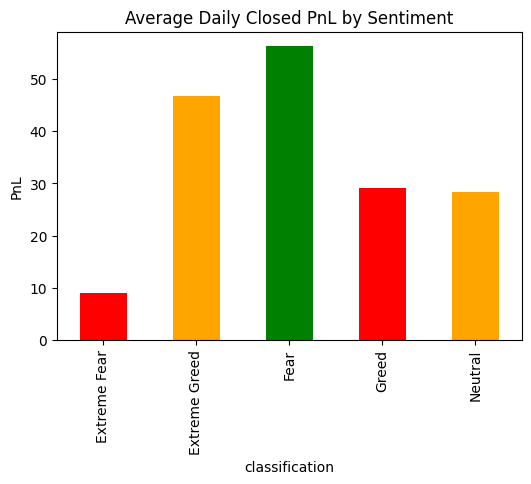

In [28]:
# Average PnL by sentiment
plt.figure(figsize=(6,4))
daily_summary.groupby("classification")["Closed PnL"].mean().plot(
    kind='bar', color=['red','orange','green']
)
plt.title("Average Daily Closed PnL by Sentiment")
plt.ylabel("PnL")
plt.show()

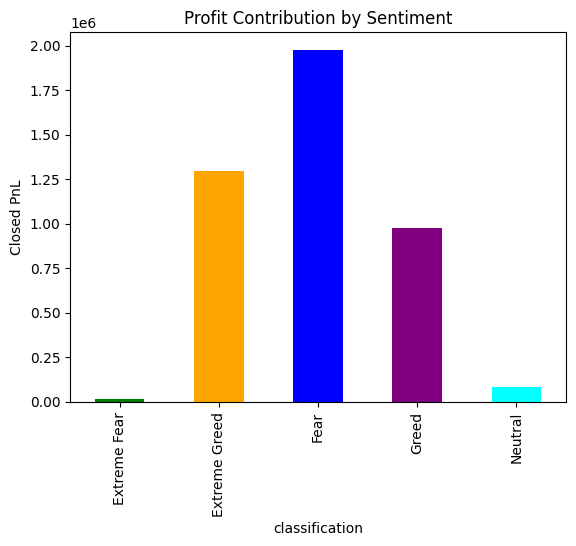

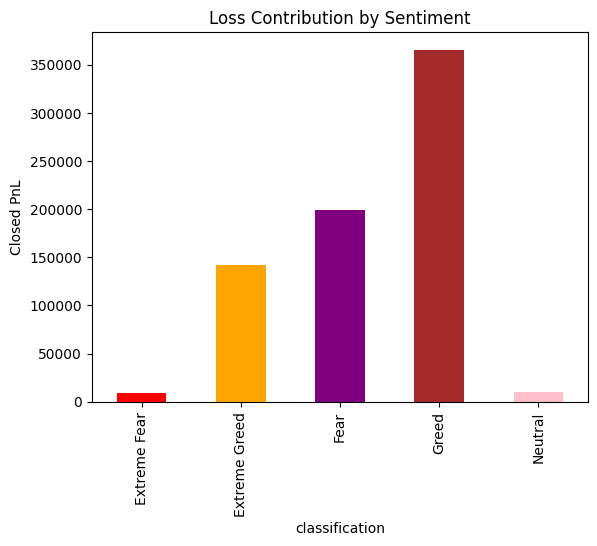

In [54]:
# Profits only
profit = merged[merged['Closed PnL'] > 0].groupby('classification')['Closed PnL'].sum()
profit.plot(kind='bar', color=['green','orange','blue','purple','cyan'][:len(profit)])
plt.title("Profit Contribution by Sentiment")
plt.ylabel("Closed PnL")
plt.show()

# Losses only
loss = merged[merged['Closed PnL'] < 0].groupby('classification')['Closed PnL'].sum().abs()
loss.plot(kind='bar', color=['red','orange','purple','brown','pink'][:len(loss)])
plt.title("Loss Contribution by Sentiment")
plt.ylabel("Closed PnL")
plt.show()


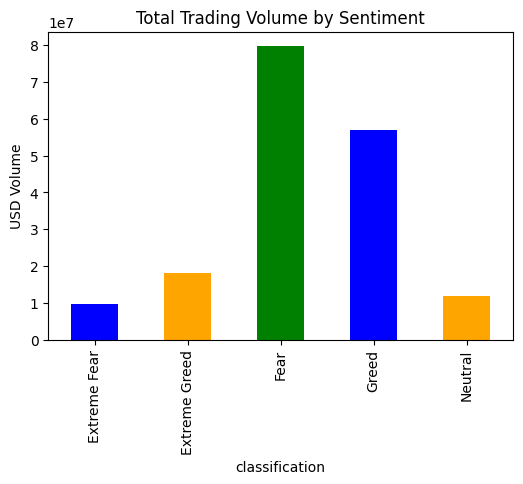

In [29]:
# Total Volume by sentiment
plt.figure(figsize=(6,4))
daily_summary.groupby("classification")["Size USD"].sum().plot(
    kind='bar', color=['blue','orange','green']
)
plt.title("Total Trading Volume by Sentiment")
plt.ylabel("USD Volume")
plt.show()

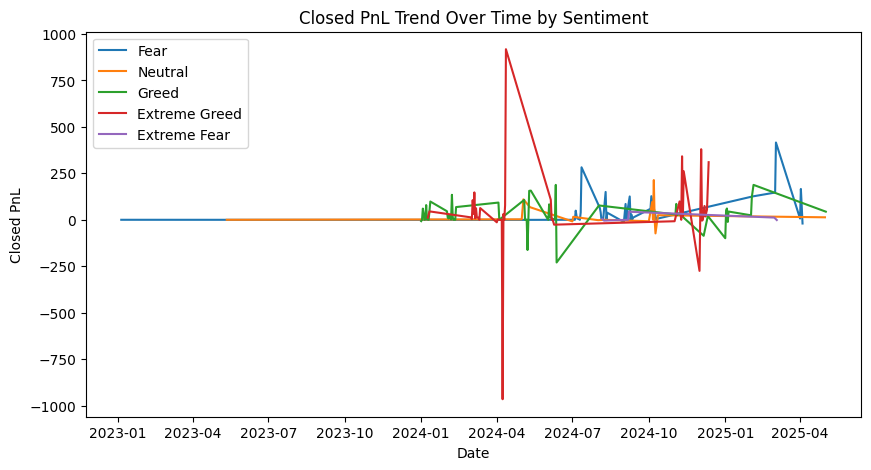

In [30]:
# Trend over time (PnL)
plt.figure(figsize=(10,5))
for sentiment in daily_summary['classification'].unique():
    subset = daily_summary[daily_summary['classification']==sentiment]
    plt.plot(subset['date'], subset['Closed PnL'], label=sentiment)
plt.title("Closed PnL Trend Over Time by Sentiment")
plt.xlabel("Date")
plt.ylabel("Closed PnL")
plt.legend()
plt.show()

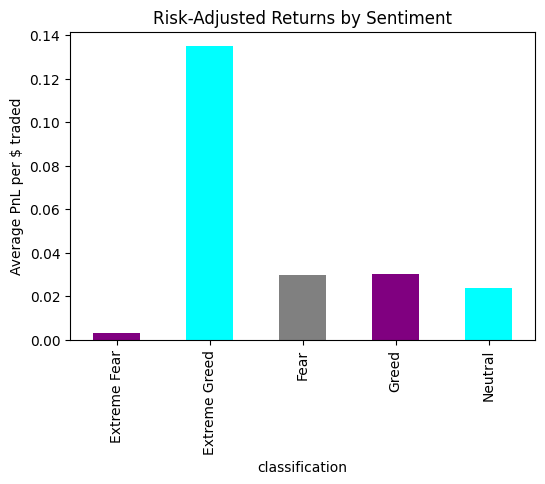

Risk-adjusted returns by sentiment:
classification
Extreme Fear     0.003188
Extreme Greed    0.134938
Fear             0.029822
Greed            0.030462
Neutral          0.023814
Name: pnl_per_usd, dtype: float64


In [31]:
merged['pnl_per_usd'] = merged['Closed PnL'] / merged['Size USD']
risk_adj = merged.groupby('classification')['pnl_per_usd'].mean()

plt.figure(figsize=(6,4))
risk_adj.plot(kind='bar', color=['purple','cyan','grey'])
plt.title("Risk-Adjusted Returns by Sentiment")
plt.ylabel("Average PnL per $ traded")
plt.show()

print("Risk-adjusted returns by sentiment:")
print(risk_adj)


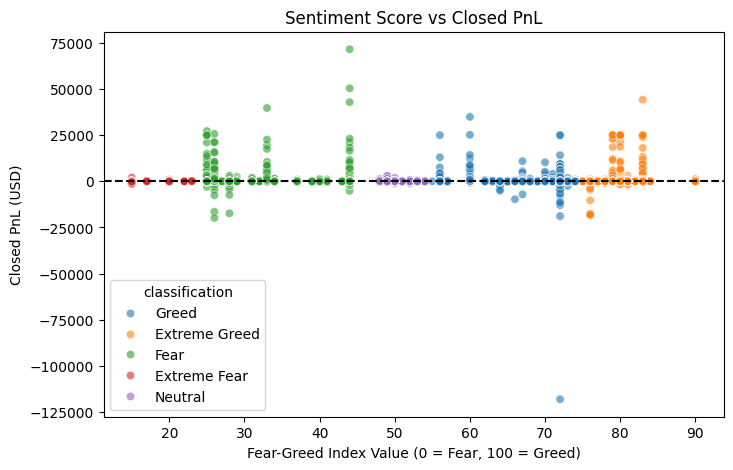

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=merged, x='value', y='Closed PnL', hue='classification', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.title("Sentiment Score vs Closed PnL")
plt.xlabel("Fear-Greed Index Value (0 = Fear, 100 = Greed)")
plt.ylabel("Closed PnL (USD)")
plt.show()

📊 Profitability by Sentiment
       Sentiment  Total Profit  Avg Profit per Trade  No. of Trades  \
0   Extreme Fear  4.399937e+03              1.891632           2326   
1  Extreme Greed  1.156894e+06            205.816345           5621   
2           Fear  1.779226e+06            128.287950          13869   
3          Greed  6.096325e+05             53.988003          11292   
4        Neutral  7.465674e+04             27.088803           2756   

   Total Volume  
0    9580240.04  
1   18223760.27  
2   79674391.06  
3   57045815.74  
4   11939551.21  


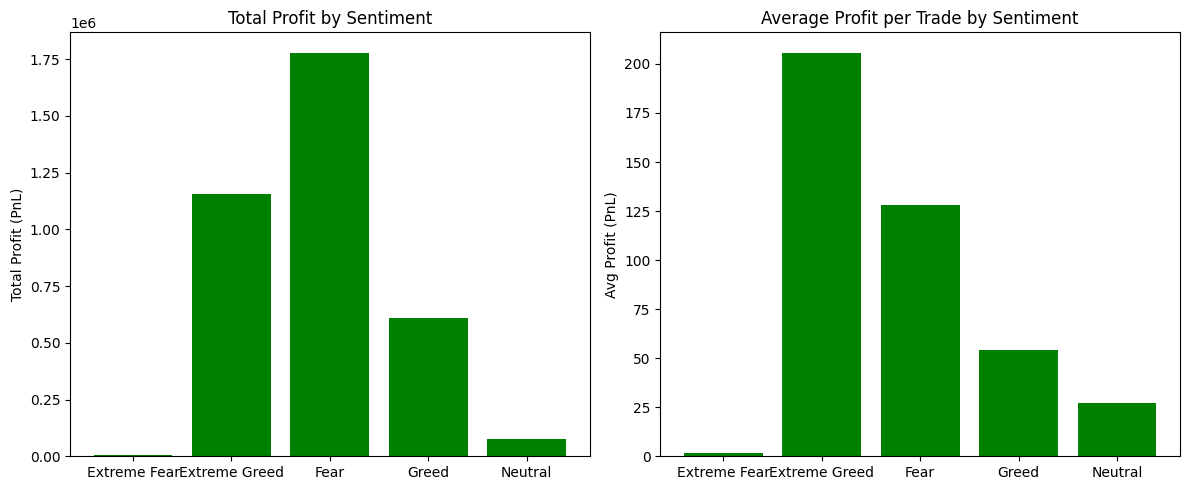

In [59]:

# Aggregate profit by sentiment
profit_by_sentiment = merged.groupby("classification").agg({
    "Closed PnL": ["sum", "mean", "count"],
    "Size USD": "sum"
}).reset_index()
profit_by_sentiment.columns = ["Sentiment", "Total Profit", "Avg Profit per Trade", "No. of Trades", "Total Volume"]

print("📊 Profitability by Sentiment")
print(profit_by_sentiment)
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Total Profit
axs[0].bar(
    profit_by_sentiment["Sentiment"],
    profit_by_sentiment["Total Profit"],
    color=['green' if x>0 else 'red' for x in profit_by_sentiment["Total Profit"]]
)
axs[0].set_title("Total Profit by Sentiment")
axs[0].set_ylabel("Total Profit (PnL)")

# Avg Profit per Trade
axs[1].bar(
    profit_by_sentiment["Sentiment"],
    profit_by_sentiment["Avg Profit per Trade"],
    color=['green' if x>0 else 'red' for x in profit_by_sentiment["Avg Profit per Trade"]]
)
axs[1].set_title("Average Profit per Trade by Sentiment")
axs[1].set_ylabel("Avg Profit (PnL)")

plt.tight_layout()
plt.show()

📊 Monthly Investment vs Profit
  YearMonth    Size USD    Closed PnL
0   2023-01      477.00      0.000000
1   2023-05    50005.83      0.000000
2   2024-01  2997004.48  58011.376422
3   2024-02  2112819.91  24241.196568
4   2024-03  3526893.52  40705.516643


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


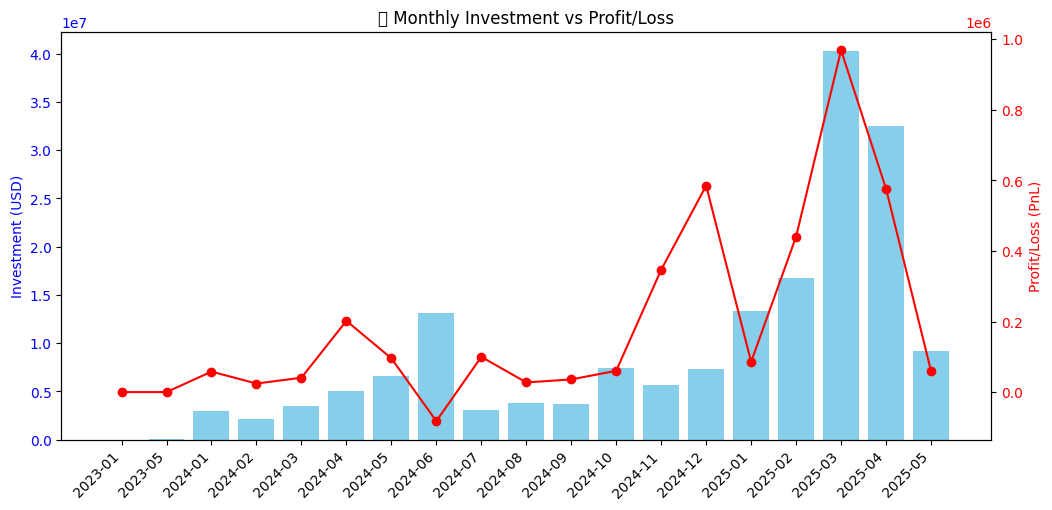

In [40]:
# Convert date to datetime (if not already)
merged['date'] = pd.to_datetime(merged['date'])

# Extract Year-Month
merged['YearMonth'] = merged['date'].dt.to_period('M')

# Group by month
monthly_summary = merged.groupby("YearMonth").agg({
    "Size USD": "sum",       # Total invested
    "Closed PnL": "sum"      # Total profit/loss
}).reset_index()

# Convert YearMonth to string for plotting
monthly_summary['YearMonth'] = monthly_summary['YearMonth'].astype(str)

print("📊 Monthly Investment vs Profit")
print(monthly_summary.head())

# --- Visualization ---
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Investment (USD)
ax1.bar(monthly_summary["YearMonth"], monthly_summary["Size USD"],
        color='skyblue', label="Total Investment (USD)")
ax1.set_ylabel("Investment (USD)", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Profit (PnL) on secondary axis
ax2 = ax1.twinx()
ax2.plot(monthly_summary["YearMonth"], monthly_summary["Closed PnL"],
         color='red', marker='o', label="Total Profit/Loss")
ax2.set_ylabel("Profit/Loss (PnL)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Titles and Legends
plt.title("📈 Monthly Investment vs Profit/Loss")
fig.autofmt_xdate(rotation=45)

plt.show()
